In [1]:
import os
import imageio
from skimage.io import imread_collection

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LeakyReLU

import statsmodels.api as sm

In [2]:
## directories
paths = ['images',
            'images/1dim_uni_to_stnormal',
                'images/1dim_uni_to_stnormal/gif',
                'images/1dim_uni_to_stnormal/final',
            'images/1dim_norm(8,1)_to_stnormal',
                'images/1dim_norm(8,1)_to_stnormal/gif',
                'images/1dim_norm(8,1)_to_stnormal/final',
        ]

for i in paths:
    if not os.path.exists(i):
        os.makedirs(i)

In [3]:
def generate_noise(samples, dimensions=2):
    return np.random.uniform(-1,1, (samples, dimensions))
    #return np.random.normal(8,1, (samples,dimensions))
    
def generate_data(samples, dimensions=2):
    return np.random.normal(0,1, (samples, dimensions))

# mapping (R,R)-->([-1,1], [-1,1])
def generator(latent_dim, output_dim):
    model = Sequential()
    model.add(Dense(16, activation = 'relu', kernel_initializer= 'he_uniform', input_dim = latent_dim))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(Dense(16, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(Dense(16, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(Dense(16, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(Dense(output_dim, activation = 'linear'))
    model.add(Dense(output_dim))
    return model

def discriminator(dim):
    model = Sequential()
    model.add(Dense(64, activation = 'relu', kernel_initializer = 'he_uniform', input_dim = dim))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(Dense(64, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(Dense(64, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = Adam(learning_rate = 0.002, beta_1 = 0.5), metrics = ['accuracy'], loss = 'binary_crossentropy')
    return model

# build GAN given a discriminator and a generator
def GAN(G, D):
    D.trainable = False
    model = Sequential()
    model.add(G)
    model.add(D)
    model.compile(optimizer = Adam(learning_rate = 0.001, beta_1 = 0.5), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [4]:
# VISUALIZATION

def plots(G, D, step, D_loss, G_loss, filename):
    file, ax = plt.subplots(2, 2, figsize=(8,8))
    
    # plot losses
    ax[0,0].plot(step, G_loss, label='G loss', 
                    c='darkgreen', zorder=50, alpha=0.8,)
    ax[0,0].plot(step, D_loss, label='D loss',
                    c='darkblue', zorder=55, alpha=0.8,)
    ax[0,0].set_xlim(0, max(max(step), batches)+5)
    #ax[0,0].set_ylim(0.45, 1.0)
    ax[0,0].set_xlabel('Epoch')
    ax[0,0].legend(loc=1, frameon=False)
    
    # plot real and generated samples
    fake_samples = G.predict(test_noise, batch_size=len(test_noise))
    x_val = np.linspace(-3, 3, 301)
    y_val = stats.norm(0,1).pdf(x_val)
    ax[0,1].plot(x_val, y_val, color='k', label='real')
    ax[0,1].fill_between(x_val, np.zeros(len(x_val)), y_val, color='k', alpha=0.6)
    sns.kdeplot(fake_samples.flatten(), color='green', alpha=0.6, label='GAN', ax=ax[0,1], shade=True)
    #ax[0,1].set_xlim(-3,3)
    ax[0,1].legend(loc=1, frameon=False)
    ax[0,1].set_xlabel('Sample Space')
    ax[0,1].set_ylabel('Density')
    
    # plot confidence of the discriminator
    confi = D.predict(grid_sample, batch_size=size).flatten()
    ax[1,0].plot(grid_sample.flatten(), confi, c='b')
    lower, upper = -3, 3
    for i in range(0, len(confi), 50):
        if i==0:
            continue
        ax[1,0].plot([(i/len(confi))*(upper-lower) + lower, ]*2,
                        [0, confi[i]], c='b')
    ax[1,0].fill_between(grid_sample.flatten(), np.zeros(len(confi)), confi, color='b', alpha=0.6)
    ax[1,0].set_xlabel('Sample Space')
    ax[1,0].set_ylabel('Discriminator Value')
    ax[1,0].set_xlim(lower,upper)
    ax[1,0].set_ylim(0.0,1.0)
        
    # Q-Q Plot
    qq = fake_samples.reshape(len(fake_samples,))
    sm.qqplot(qq, line='45', markerfacecolor='mediumblue', markeredgecolor='mediumblue',  ax=ax[1,1])
    
    plt.tight_layout()
    plt.savefig(filename, transparent=True)
    return

In [5]:
# PARAMETERS
# latent dimension
latent_dim = 1

# subsample for gif, set to zero if no gif wanted
batches = 500

# batch size
size = 512

# plotting frequency for Ggif
freq = 1

# samples for final plot
test_noise = generate_noise(5000, latent_dim)
test_samples = generate_data(5000, latent_dim)

G = generator(latent_dim, 1)
D = discriminator(1)
GAN = GAN(G, D)

grid_sample = np.linspace(-3, 3, 603)[1:-1].reshape((-1, 1))

step = []
D_acc = []
G_acc = []
D_loss = []
G_loss = []
count = []

In [6]:
# produce pictures for GIF
for k in range(batches):
    print(f'step: {k+1}/{batches}', end='\r')
    
    # train discriminator
    D.trainable = True
    real_data = generate_data(size//2,latent_dim)
    fake_data = G.predict(generate_noise(size//2, latent_dim), batch_size=size//2)
    data = np.concatenate((real_data, fake_data), axis=0)
    
    real_labels = np.ones((size//2, 1))
    fake_labels = np.zeros((size//2,1))
    labels = np.concatenate((real_labels, fake_labels), axis=0)
    
    _D_loss, _D_acc = D.train_on_batch(data, labels)
    
    # train generator
    D.trainable = False
    noise = generate_noise(size, latent_dim)
    labels = np.ones((size, 1))
    _G_loss, _G_acc = GAN.train_on_batch(noise, labels)
    
    if k % freq == 0:
        step.append(k)
        D_loss.append(_D_loss)
        G_loss.append(_G_loss)
        plots(G=G, D=D, step=step, D_loss=D_loss, G_loss=G_loss,
                filename=f'images/1dim_uni_to_stnormal/gif/pic.{k+1:03d}.jpeg')
                #filename=f'images/1dim_norm(8,1)_to_stnormal/gif/pic.{k:03d}.jpeg')
        plt.close()
print()

#make GIF
directory = 'images/1dim_uni_to_stnormal/gif/*.jpeg'
#directory = 'images/1dim_norm(8,1)_to_stnormal/gif/*.jpeg'
images = imread_collection(directory)
imageio.mimsave('images/1dim_uni_to_stnormal/final/animation.mp4', images, quality=9)
#imageio.mimsave('images/1dim_norm(8,1)_to_stnormal/final/animation.mp4', images, quality=9)

step: 500/500


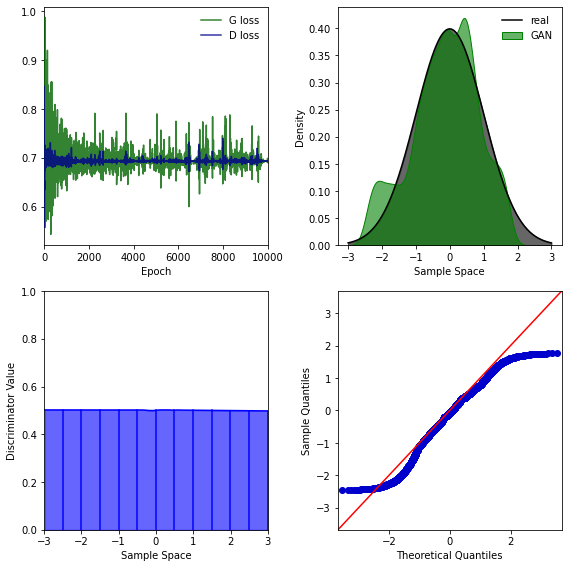

In [7]:
total_steps = 10000

for k in range(total_steps):
    print(f'step: {k+1}/{total_steps}', end='\r')
    
    # train discriminator
    D.trainable = True
    real_data = generate_data(size//2,latent_dim)
    fake_data = G.predict(generate_noise(size//2, latent_dim), batch_size=size//2)
    data = np.concatenate((real_data, fake_data), axis=0)
    
    real_labels = np.ones((size//2, 1))
    fake_labels = np.zeros((size//2,1))
    labels = np.concatenate((real_labels, fake_labels), axis=0)
    
    _D_loss, _D_acc = D.train_on_batch(data, labels)
    
    # train generator
    D.trainable = False
    noise = generate_noise(size, latent_dim)
    labels = np.ones((size, 1))
    _G_loss, _G_acc = GAN.train_on_batch(noise, labels)    
    
    if k % freq == 0:
        step.append(k)
        D_loss.append(_D_loss)
        G_loss.append(_G_loss)
        
plots(G=G, D=D, step=step, D_loss=D_loss, G_loss=G_loss, filename=f'images/1dim_uni_to_stnormal/final/plot_step{k+1:03d}.png')
#plots(G=G, D=D, step=step, D_loss=D_loss, G_loss=G_loss, filename=f'images/1dim_norm(8,1)_to_stnormal/plot_step{k+1:03d}.png')